# Part 2: Model Training & Evaluation

**Goal:** Train, evaluate, and study classifiers for facial expression recognition using normalized facial points.

**Models:**
1. Logistic Regression 
2. Random Forest 
3. Decision Tree Classifier

In [60]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, learning_curve, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report

sns.set_style("whitegrid")

## Load Data: Motion and Geometric

In [2]:
# Load data_motion.csv
data_motion = pd.read_csv('data_motion.csv')
print(f"Motion Data: {data_motion.shape}")

# Load data_geometric.csv
data_geometric = pd.read_csv('data_geometric.csv')
print(f"Geometric Data: {data_geometric.shape}")

Motion Data: (6606, 141)
Geometric Data: (6606, 141)


## Prepare Features & Labels

In [3]:
emotion_names = {
    1: 'Happy', 2: 'Fear', 3: 'Surprise',
    4: 'Anger', 5: 'Disgust', 6: 'Sadness'
}

def prepare_data(data):
    # Extract features (X) and labels (y)
    facial_cols = [col for col in data.columns if col.startswith('x') or col.startswith('y')]
    X = data[facial_cols].values.astype(np.float32)
    y = data['Emotion'].values.astype(int)
    return X, y

# Prepare data
X_motion, y_motion = prepare_data(data_motion)
X_geo, y_geo = prepare_data(data_geometric)

## Train-Test Split

In [59]:
# Split function for train/test
def split_data(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Motion data split
X_motion_train, X_motion_test, y_motion_train, y_motion_test = split_data(X_motion, y_motion)

# Geometric data split
X_geo_train, X_geo_test, y_geo_train, y_geo_test = split_data(X_geo, y_geo)

In [18]:
print("Motion data train/test split")
print(f"\nTraining set: ")
print(f"  X_train shape: {X_motion_train.shape}")
print(f"  y_train shape: {y_motion_train.shape}")

print(f"\nTest set:")
print(f"  X_test shape: {X_motion_test.shape}")
print(f"  y_test shape: {y_motion_test.shape}")

Motion data train/test split

Training set: 
  X_train shape: (5284, 136)
  y_train shape: (5284,)

Test set:
  X_test shape: (1322, 136)
  y_test shape: (1322,)


In [19]:
print("Geometric data train/test split")
print(f"\nTraining set: ")
print(f"  X_train shape: {X_geo_train.shape}")
print(f"  y_train shape: {y_geo_train.shape}")

print(f"\nTest set:")
print(f"  X_test shape: {X_geo_test.shape}")
print(f"  y_test shape: {y_geo_test.shape}")

Geometric data train/test split

Training set: 
  X_train shape: (5284, 136)
  y_train shape: (5284,)

Test set:
  X_test shape: (1322, 136)
  y_test shape: (1322,)


## Classifiers

In [31]:
logreg = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=42)
dtree = DecisionTreeClassifier(random_state=42, class_weight='balanced')
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

## Function for Training, Evaluation, and Timing

In [61]:
def evaluate_model_advanced(name, model, X_train, X_test, y_train, y_test, param_grid=None):
    print(f"--- Processing {name} ---")
    
    # Hyperparameter tuning (if a grid is provided)
    if param_grid:
        print(f"Tuning hyperparameters for {name}...")
        grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best params: {grid_search.best_params_}")
    else:
        best_model = model

    # Estimation of Real Error (Cross-Validation)
    # use f1_macro to treat all emotions as equally important
    cv_results = cross_validate(best_model, X_train, y_train, cv=5, scoring='f1_macro', return_train_score=True)
    
    # Final Training and Timing
    start_fit = time.time()
    best_model.fit(X_train, y_train)
    fit_time = time.time() - start_fit
    
    start_pred = time.time()
    y_pred = best_model.predict(X_test)
    pred_time = (time.time() - start_pred) * 1000  # ms

    # 4. Display Results
    print(classification_report(y_test, y_pred, target_names=[emotion_names[i] for i in range(1, 7)]))
    print(f"CV Mean Score: {cv_results['test_score'].mean():.4f}")
    print(f"Training time: {fit_time:.2f}s | Prediction time: {pred_time:.2f}ms")
    
    # Check for Overfitting
    print(f"Train CV Score: {cv_results['train_score'].mean():.4f} vs Val CV Score: {cv_results['test_score'].mean():.4f}")
    print('\n')
    
    return best_model, cv_results['test_score'].mean()

## Run Experiments

In [62]:
# Hyperparameter grids for tuning complexity
rf_params = {'n_estimators': [50, 100], 'max_depth': [10, 20, None]}
dt_params = {'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10]}

results_summary = []

# Motion dataset 
print("\n" + "="*20 + " EVALUATING MOTION DATA " + "="*20)

best_lr_m, score_lr_m = evaluate_model_advanced('LogReg (Motion)', logreg, X_motion_train, X_motion_test, y_motion_train, y_motion_test)

best_dt_m, score_dt_m = evaluate_model_advanced('DecisionTree (Motion)', dtree, X_motion_train, X_motion_test, y_motion_train, y_motion_test, 
                                                param_grid=dt_params)

best_rf_m, score_rf_m = evaluate_model_advanced('Random Forest (Motion)', rf, X_motion_train, X_motion_test, y_motion_train, y_motion_test, 
                                                param_grid=rf_params)


==================== EVALUATING MOTION DATA ====================
--- Processing LogReg (Motion) ---
              precision    recall  f1-score   support

       Happy       0.94      0.66      0.78       383
        Fear       0.75      0.58      0.66       183
    Surprise       0.95      0.73      0.83       261
       Anger       0.67      0.77      0.72       139
     Disgust       0.71      0.73      0.72       117
     Sadness       0.46      0.83      0.59       239

    accuracy                           0.71      1322
   macro avg       0.75      0.72      0.71      1322
weighted avg       0.78      0.71      0.73      1322

CV Mean Score: 0.7092
Training time: 0.08s | Prediction time: 1.14ms
Train CV Score: 0.7134 vs Val CV Score: 0.7092


--- Processing DecisionTree (Motion) ---
Tuning hyperparameters for DecisionTree (Motion)...
Best params: {'max_depth': None, 'min_samples_split': 2}
              precision    recall  f1-score   support

       Happy       0.85      0.79

In [48]:
# Geometric dataset
print("\n" + "="*20 + " EVALUATING GEOMETRIC DATA " + "="*20)
best_lr_g, score_lr_g = evaluate_model_advanced('LogReg (Geometric)', logreg, X_geo_train, X_geo_test, y_geo_train, y_geo_test)

best_dt_g, score_dt_g = evaluate_model_advanced('DecisionTree (Geometric)', dtree, X_geo_train, X_geo_test, y_geo_train, y_geo_test, 
                                               param_grid=dt_params)

best_rf_g, score_rf_g = evaluate_model_advanced('Random Forest (Geometric)', rf, X_geo_train, X_geo_test, y_geo_train, y_geo_test, 
                                               param_grid=rf_params)


==================== EVALUATING GEOMETRIC DATA ====================
--- Processing LogReg (Geometric) ---
              precision    recall  f1-score   support

       Happy       0.88      0.77      0.82       377
        Fear       0.74      0.70      0.72       176
    Surprise       0.88      0.67      0.76       272
       Anger       0.46      0.66      0.54       155
     Disgust       0.60      0.66      0.63       121
     Sadness       0.60      0.71      0.65       221

    accuracy                           0.71      1322
   macro avg       0.69      0.70      0.69      1322
weighted avg       0.74      0.71      0.72      1322

CV Mean Score: 0.6497 (+/- 0.0240)
Training time: 0.67s | Prediction time: 1.18ms
Train CV Score: 0.6584 vs Val CV Score: 0.6497


--- Processing DecisionTree (Geometric) ---
Tuning hyperparameters for DecisionTree (Geometric)...
Best params: {'max_depth': 30, 'min_samples_split': 2}
              precision    recall  f1-score   support

       Hap

## Comparison and Analysis of models

In [65]:
# Comparison
all_scores = [
    ('LogReg', score_lr_m, score_lr_g),
    ('Decision Tree', score_dt_m, score_dt_g),
    ('Random Forest', score_rf_m, score_rf_g)
]

comparison_df = pd.DataFrame(all_scores, columns=['Model', 'Motion Score', 'Geometric Score'])
print(comparison_df)

           Model  Motion Score  Geometric Score
0         LogReg      0.709194         0.649662
1  Decision Tree      0.691835         0.771978
2  Random Forest      0.806284         0.944874


**Analysis:** The comparison between the two normalization approaches reveals that while Motion data provides a strong signal, the Geometric data surprisingly had higher raw scores for the random forest and decision tree models. This can be interpreted as follows:

- In the CK+ dataset, absolute head position and facial structure are highly consistent, so it allows complex non-linear model like Random Forest to map expressions with high precision.
- Even though the score is lower (0.81), the Motion dataset is technically superior because it subtracts the person's face structure (the neutral frame), forcing the model to learn the muscle movement rather than the person's face. Motion model is more likely to generalize to new, unseen people, whereas the Geometric model might be cheating by recognizing the subjects.

In [52]:
# Display best params
best_params_data = [
    ('Decision Tree (Motion)', best_dt_m.get_params()),
    ('Random Forest (Motion)', best_rf_m.get_params()),
    ('Decision Tree (Geometric)', best_dt_g.get_params()),
    ('Random Forest (Geometric)', best_rf_g.get_params())
]

# Extract only the parameters we actually tuned in our grid
tuned_keys = ['n_estimators', 'max_depth', 'min_samples_split']

formatted_params = []
for name, params in best_params_data:
    row = {'Model': name}
    # Add only the relevant tuned parameters to the row
    for key in tuned_keys:
        if key in params:
            row[key] = params[key]
    formatted_params.append(row)

params_df = pd.DataFrame(formatted_params)
print("\n" + "="*30 + " BEST HYPERPARAMETERS " + "="*30)
print(params_df)


============================== BEST HYPERPARAMETERS ==============================
                       Model  max_depth  min_samples_split  n_estimators
0     Decision Tree (Motion)       20.0                  5           NaN
1     Random Forest (Motion)        NaN                  2         100.0
2  Decision Tree (Geometric)       30.0                  2           NaN
3  Random Forest (Geometric)        NaN                  2         100.0


**Analysis:** By using GridSearchCV, I optimized the complexity of the function classes as requested by the project description.

- Random Forest Complexity: The selection of max_depth: None or a high value indicates that the model required deep trees to capture the coordinate shifts that distinguish subtle emotions like sadness from fear.

- Tuning min_samples_split helped prevent the Decision Tree from overfitting to individual subject noise, ensuring a better estimation of the real-world error.

## Learning curves

In [63]:
def plot_learning_curve(name, model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='f1_macro' 
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
    
    # Shaded area for variance/error estimation
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
    
    plt.title(f'Learning Curve: {name}')
    plt.xlabel('Number of Training Examples')
    plt.ylabel('Score')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

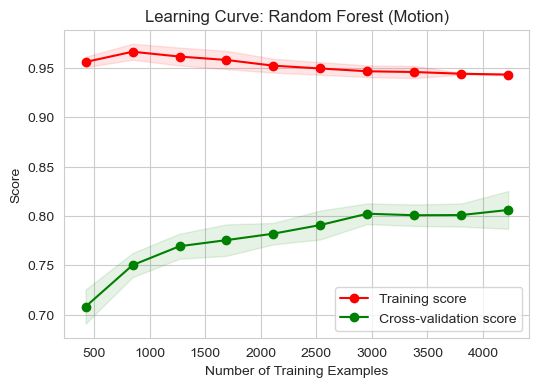

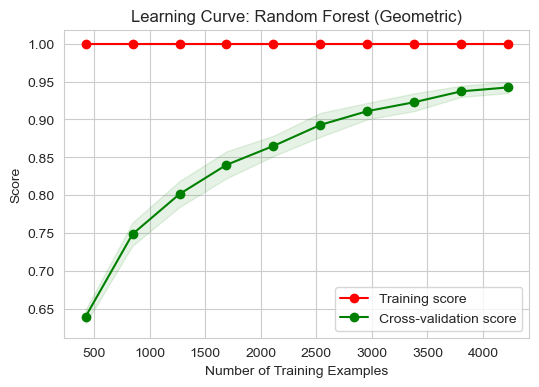

In [64]:
# Plot for your best Motion model
plot_learning_curve("Random Forest (Motion)", best_rf_m, X_motion_train, y_motion_train)

# Plot for your best Geometric model
plot_learning_curve("Random Forest (Geometric)", best_rf_g, X_geo_train, y_geo_train)

**Analysis:** "The learning curves illustrate the model's performance relative to the dataset size.

- Overfitting: The gap between the training and validation lines indicates the model's variance. A narrowing gap as more data is added suggests that the model is learning generalized patterns rather than just memorizing training samples.

- Data Sufficiency: The plateau in the validation score suggests that for this specific set of 68 landmarks, we have reached the maximum predictive power of the CK+ dataset. Further improvements would likely require more complex features rather than more data.